In [ ]:
# Drive mounting
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('/content/drive/My Drive/ADM/HW4/')

Mounted at /content/drive/


In [ ]:
# Useful libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
np.set_printoptions(suppress = True)

import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster, linkage
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from pathlib import Path, PurePath
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
import plotly.express as px

# Importing our modules to address all the exercise
import utilities as u
import first as f
import queries as q
import ourKmeans as okm

In [ ]:
data_folder = Path("/content/drive/MyDrive/ADM-HW4/data/mp3_dataset")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

In [ ]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

# LSH algorithm:
- **Shingling**: we want to collect, for each track, a list of tuples, where each tuple has position (index in the *onset_env* list, gave by the list *peaks*) and intensity (in frequence) of each peak, we will use these values as **shingles**, and, we build the **shingles matrix**.
- **Minhash**: we do permutations to create a **signature** for each song.
- **Buckets**: we divide the signatures in **band** of b rows and we put the songs that have similar band (according to a fixed threshold) in the same bucket.
- **Matching process**: we compute the same algorithm on the queries and we put them in the bucket that contains the most similar element.

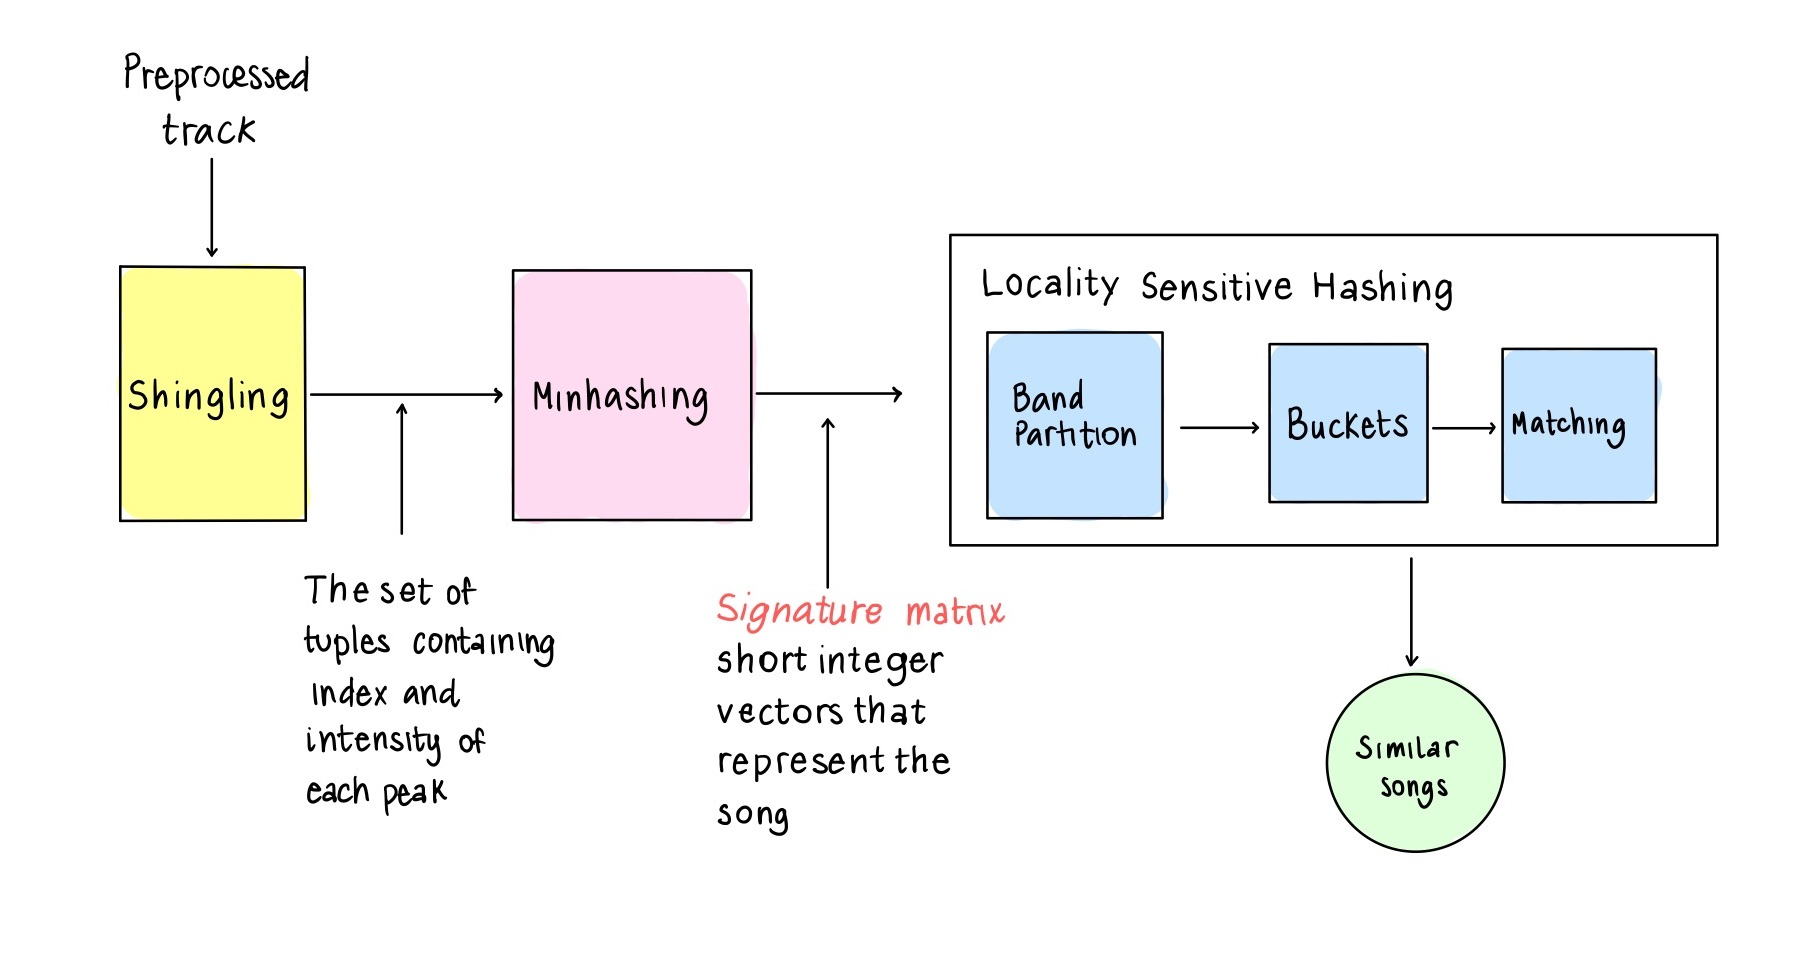

In [ ]:
ipd.Image('LSH1.jpg')

From the set_peaks, we create the **shingle matrix**:
- n rows = length of set_peaks 
- n cols = number of tracks

In [ ]:
peaks_position_total, set_peaks = f.take_peaks()
shingles = f.create_shingles_matrix(peaks_position_total, set_peaks)

### MinHash 
The hash function is the index of the firts row, in the permuted order, in which the column takes value 1. We do it 30 times to create a signature of length 30.

In [ ]:
signature = f.create_signature_matrix(len(peaks_position_total), shingles)

### Create buckets
We set the bandwidth as 10, in this way we have 30/10 = 3 bands for each signature. Each band will represent the key of the buckets dictionary, which has, for each band, a list of tuple containing the index and the signature of the song that contains that band.

In [ ]:
buckets = f.create_buckets(signature, len(peaks_position_total), 10)

## Shingling & MinHash on queries
We compute the same steps on the query tracks, in order to have their signature and be able to put them it the bucket that contains the most similar tracks.

In [ ]:
peaks_position_query = q.take_peaks()
shingles_query = q.create_shingles(set_peaks, peaks_position_query)
signature_query = q.create_signature(peaks_position_query, shingles_query)

In [ ]:
results = q.insert_in_buckets(signature_query, peaks_position_query, 10)
q.print_res(results)

1 aerosmith/Aerosmith/03-Dream_On
2 queen/The_Works/06-I_Want_To_Break_Free
3 u2/October/07-October
4 beatles/The_White_Album_Disc_1/04-Ob-La-Di_Ob-La-Da
5 radiohead/OK_Computer/06-Karma_Police
6 led_zeppelin/Led_Zeppelin_II/05-Heartbreaker
7 fleetwood_mac/Rumours/05-Go_Your_Own_Way
8 green_day/American_Idiot/01-American_Idiot
9 depeche_mode/Some_Great_Reward/06-Somebody
10 steely_dan/Katy_Lied/01-Black_Friday


# Alternative algorithm: 
Since we observed that we had 1 bucket per band, we tried to compute the LSH algorithm without including the step where we create the buckets.
Actually, the outcome is the same.
**IDEA** : As we did before, we collect, for each track, a list of tuples, where each tuple has position (index in the *onset_env* list, gave by the list *peaks*) and intensity (in frequence) of each peak, we will use these values as **shingles**, and, once built the **shingles matrix**, we do permutations (as the minhash function) to create a **signature** for each song. Then we directly compare songs, by comparing their signature.
Briefly speaking, we skip the step where we divide the signatures into bands and create buckets.

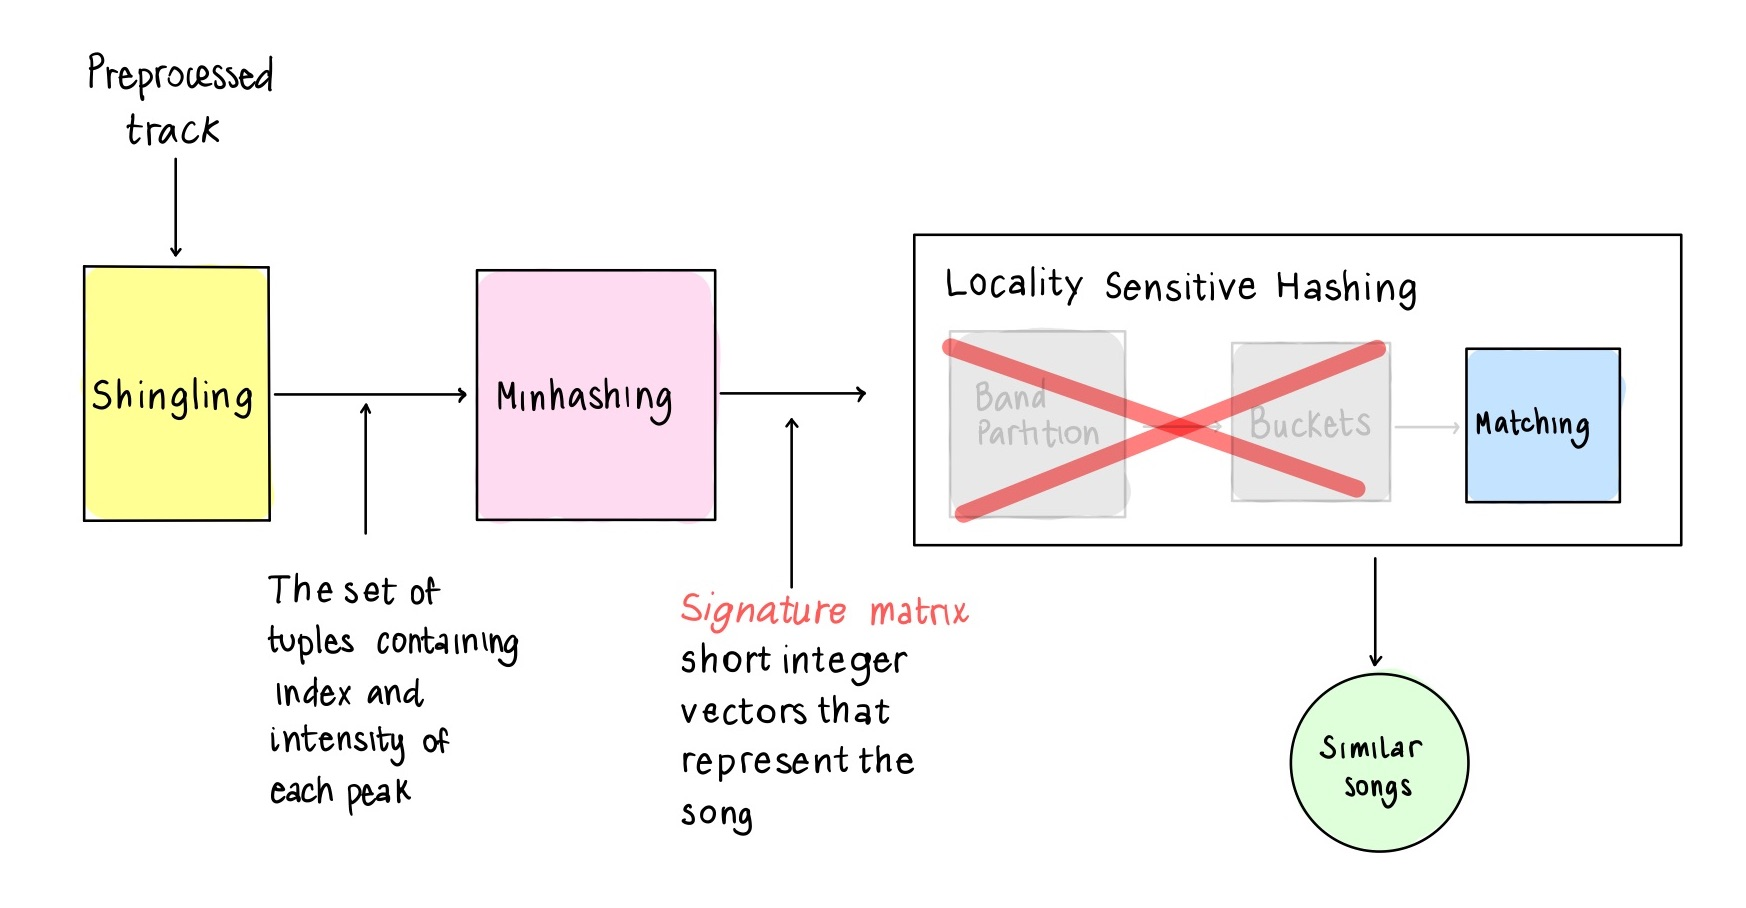

In [ ]:
ipd.Image('LSH2.jpg')

From the set_peaks, we create the **shingle matrix**:
- n rows = length of set_peaks 
- n cols = number of tracks
After that we compute 30 permutations of the rows of the shingle matrix to build the signature of each song (of length 30). We choose 30 as a tradeoff between computational complexity and robusteness of the model.

Now, we compare each query song with the tracks in the database to see witch ones actually match.
We do this step by using their signature.
We tried to set 3 different threshold: 0, 3, 6.
The **THRESHOLD** parameter is the number of elements in the signature being exactly the same between the query track and the track in our database.
Of course, while the threshold increases, the model becomes more robust, hence, more precise, but we want some flexibility to let the song matches even if some they differs for some peaks.
- THRESHOLD ≤ 0.09 --> these values are too small, so a query song matches with more than one track in the database
- 0.1 ≤ THRESHOLD ≤ 0.5 --> this turn out to be the best range of values, all the songs match with the right one, except from the second one, because we haven't it in our database
- THRESHOLD ≥ 0.55 --> these values are too high, not all the songs match because we pretend to have an high similarity to affirm that two songs match.

In [ ]:
treshold = [0.09, 0.5, 0.55]
for tr in treshold:
    print("\nTRESHOLD = " + str(tr))
    q.alternative_LSH(len(peaks_position_query), len(peaks_position_total), signature_query, signature, tr)


TRESHOLD = 0.09
1 aerosmith/Aerosmith/03-Dream_On
2 queen/The_Works/06-I_Want_To_Break_Free
3 u2/October/07-October
4 beatles/The_White_Album_Disc_1/04-Ob-La-Di_Ob-La-Da
5 radiohead/OK_Computer/06-Karma_Police
6 led_zeppelin/Led_Zeppelin_II/05-Heartbreaker
7 fleetwood_mac/Rumours/05-Go_Your_Own_Way
8 green_day/American_Idiot/01-American_Idiot
9 depeche_mode/Some_Great_Reward/06-Somebody
10 radiohead/Kid_A/02-Kid_A
10 steely_dan/Katy_Lied/01-Black_Friday

TRESHOLD = 0.5
1 aerosmith/Aerosmith/03-Dream_On
2 queen/The_Works/06-I_Want_To_Break_Free
3 u2/October/07-October
4 beatles/The_White_Album_Disc_1/04-Ob-La-Di_Ob-La-Da
5 radiohead/OK_Computer/06-Karma_Police
6 led_zeppelin/Led_Zeppelin_II/05-Heartbreaker
7 fleetwood_mac/Rumours/05-Go_Your_Own_Way
8 green_day/American_Idiot/01-American_Idiot
10 steely_dan/Katy_Lied/01-Black_Friday

TRESHOLD = 0.55
1 aerosmith/Aerosmith/03-Dream_On
2 queen/The_Works/06-I_Want_To_Break_Free
3 u2/October/07-October
4 beatles/The_White_Album_Disc_1/04-Ob-

## ES 2

In [ ]:
pd.set_option('display.max_columns', None)

## Data wrangling, pre-processing and dimensionality reduction

Let's analyze the three datasets one at a time, choosing the variables we want to use before joining them all together.
Let's start with "echonest.csv":

In [ ]:
echonest=pd.read_csv('/content/drive/MyDrive/ADM-HW4/data/csv_files/echonest.csv',header=0)
echonest.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,metadata_album_name,metadata_artist_latitude,metadata_artist_location,metadata_artist_longitude,metadata_artist_name,metadata_release,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,tempor

In [ ]:
print("INFOS:")
echonest.info()
print("\nNULL VALUES:")
echonest.select_dtypes(include=[object]).isna().sum()

INFOS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 250 entries, track_id to temporal_features_223
dtypes: float64(244), int64(1), object(5)
memory usage: 25.0+ MB

NULL VALUES:


metadata_album_date         10412
metadata_album_name         10257
metadata_artist_location     3359
metadata_artist_name            0
metadata_release                0
dtype: int64

We analyze the 5 non numerical variables and decide to delete metadata_album_date,metadata_album_name, that have too many missing values and metadata_release that is not useful.

For what regard metadata_artist_location and name, we recode them as categorical variables and we create a new numerical version that we can use in algorithms.

In [ ]:
echonest['metadata_artist_location'] = echonest['metadata_artist_location'] .astype("category") 
echonest['code_metadata_artist_location']=pd.factorize(echonest['metadata_artist_location'])[0] + 1
echonest['metadata_artist_name'] = echonest['metadata_artist_name'] .astype("category") 
echonest['code_metadata_artist_name']=pd.factorize(echonest['metadata_artist_name'])[0] + 1

echonest=echonest.drop(['metadata_album_date','metadata_album_name','metadata_release','metadata_artist_location','metadata_artist_name','metadata_artist_location'],axis=1)

Finally we eliminate the remaining columns that contain NA, which refer to technical parameters: we have many so it is not a problem.

In [ ]:
echonest= echonest.dropna(axis=1)
echonest.shape

(13129, 240)

To reduce the number of variables we work with, we apply principal component analysis (PCA), which returns new variables as linear combinations of the starting ones along the directions of maximum variance. Why choose PCA? We really have many characteristics, even similar and related to each other such as those on kurtosi or the 'temporal_features'. On the other hand, variables such as length characterize each song. Therefore, we should remove the redundancy related to certain variables and describe each song with fewer properties according to the variances that bind them (giving greater importance to the variations characterized by greater variability),since our goal is clustering. We also don't care about variables with sparse or sparse values. That is, if a high percentage of cells do not contain actual data ("empty" or NA values).

This is exactly what the PCA tries to do, so let's perform PCA on this dataset.
(We are not considering 'track_id' that is the key to merge all the data).

In [ ]:
df_pca=echonest.loc[:, echonest.columns != 'track_id']
#scale the dataset
x = StandardScaler().fit_transform(df_pca)
pca = PCA()
principalComponents = pca.fit_transform(x)
#principalComponents.explained_variance_
principalDf = pd.DataFrame(data = principalComponents)
explained_variance = np.var(principalComponents, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
varianze=np.cumsum(explained_variance_ratio)

In [ ]:
px.area(
    x=range(1, varianze.shape[0] + 1),
    y=varianze,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In the "varianze" vector we have the cumulated variances of the new components, and we must take as many to explain at least 70% (of the total variance). But we want to explain more, like 85%.

In [ ]:
len(varianze[varianze<= 0.85])

62

We have to take 61 CP.
We create a new dataset and add 'track_id'.

In [ ]:
nuova_ech=principalDf.iloc[:,0:61]
nuova_ech.shape
nuova_ech= nuova_ech.assign(track_id=0)
nuova_ech['track_id']=echonest['track_id']
nuova_ech.shape

(13129, 62)

Let's go ahead with 'features.csv'.

In [ ]:
features=pd.read_csv('/content/drive/MyDrive/ADM-HW4/data/csv_files/features.csv')
features.shape

(106574, 519)

In [ ]:
features.head(3)

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_max_07,chroma_stft_max_08,chroma_stft_max_09,chroma_stft_max_10,chroma_stft_max_11,chroma_stft_max_12,chroma_stft_mean_01,chroma_stft_mean_02,chroma_stft_mean_03,chroma_stft_mean_04,chroma_stft_mean_05,chroma_stft_mean_06,chroma

In this dataset the variables refer to technical aspects of the songs and there are no NAs.

In [ ]:
features.isna().sum()

track_id                   0
chroma_cens_kurtosis_01    0
chroma_cens_kurtosis_02    0
chroma_cens_kurtosis_03    0
chroma_cens_kurtosis_04    0
                          ..
zcr_mean_01                0
zcr_median_01              0
zcr_min_01                 0
zcr_skew_01                0
zcr_std_01                 0
Length: 519, dtype: int64

Let's perform PCA:

In [ ]:
df_pca=features.loc[:, features.columns != 'track_id']
x = StandardScaler().fit_transform(df_pca)
pca = PCA()
principalComponents = pca.fit_transform(x)
#principalComponents.explained_variance_
principalDf = pd.DataFrame(data = principalComponents)
explained_variance = np.var(principalComponents, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
varianze_1=np.cumsum(explained_variance_ratio)

In [ ]:
px.area(
    x=range(1, varianze_1.shape[0] + 1),
    y=varianze_1,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [ ]:
len(varianze_1[varianze_1<= 0.85]) 

112

The steps are the same as above, we create a new dataset by selecting 112 CP.

In [ ]:
nuova_features=principalDf.iloc[:,0:112]
nuova_features= nuova_features.assign(track_id=0)
nuova_features['track_id']=features['track_id']
nuova_features.shape

(106574, 113)

Let's go ahead with 'tracks.csv'.

In [ ]:
tracks=pd.read_csv('/content/drive/MyDrive/ADM-HW4/data/csv_files/tracks.csv')
tracks.shape

(106574, 53)

In [ ]:
tracks.head(3)

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_id,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World


Let's start by analyzing the variables of type in and float.
The latitude and longitude float variables have many missing values ​​and are not particularly indicative, we eliminate them.
We keep all those of type int.

In [ ]:
print(tracks.select_dtypes(include=[int]).isna().sum())
# print(tracks.select_dtypes(include=[float]).isna().sum()) Stampa niente
tracks= tracks.drop(['artist_latitude','artist_longitude'],axis=1)

track_id            0
album_comments      0
album_favorites     0
album_id            0
album_listens       0
album_tracks        0
artist_comments     0
artist_favorites    0
artist_id           0
track_bit_rate      0
track_comments      0
track_duration      0
track_favorites     0
track_interest      0
track_listens       0
track_number        0
dtype: int64


In [ ]:
tracks.select_dtypes(include=[object]).isna().sum()

album_date_created            3529
album_date_released          36280
album_engineer               91279
album_information            23425
album_producer               88514
album_tags                       0
album_title                   1025
album_type                    6508
artist_active_year_begin     83863
artist_active_year_end      101199
artist_associated_labels     92303
artist_bio                   35418
artist_date_created            856
artist_location              36364
artist_members               59725
artist_name                      0
artist_related_projects      93422
artist_tags                      0
artist_website               27318
artist_wikipedia_page       100993
set_split                        0
set_subset                       0
track_composer              102904
track_date_created               0
track_date_recorded         100415
track_genre_top              56976
track_genres                     0
track_genres_all                 0
track_information   

We first delete variables that we already have and some that are not interesting.
But then we decide to first merge the three dataset and then arrange the data to have the right number of rows. (Note that set_split and set_subset were probabily used for previous classification, we don't need them).
We will not perform a dimensionality reduction with these variables.

In [ ]:
tracks=tracks.drop(['artist_name','artist_location','artist_website','artist_wikipedia_page','artist_related_projects','set_split','set_subset'],axis=1)

Merge:


In [ ]:
data=nuova_ech.merge(nuova_features, on='track_id')
data= data.merge(tracks, on='track_id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Columns: 217 entries, 0_x to track_title
dtypes: float64(173), int64(16), object(28)
memory usage: 21.8+ MB


Now we decided to drop the rows with NA in "genre_top" since it's necessary for us to work with this variable.

In [ ]:
data= data[data['track_genre_top' ].notna()]

Since there are still many NAs, in order not to obtain distorted results, we eliminate other variables that have many and not too useful ones.

In [ ]:
data.select_dtypes(include=[int]).isna().sum()
data.select_dtypes(include=[float]).isna().sum()

0_x    0
1_x    0
2_x    0
3_x    0
4_x    0
      ..
107    0
108    0
109    0
110    0
111    0
Length: 173, dtype: int64

In [ ]:
data.select_dtypes(include=[object]).isna().sum()

album_date_created           106
album_date_released         2774
album_engineer              7197
album_information           1912
album_producer              7223
album_tags                     0
album_title                    0
album_type                   196
artist_active_year_begin    7053
artist_active_year_end      8952
artist_associated_labels    7515
artist_bio                  2549
artist_date_created           41
artist_members              4690
artist_tags                    0
track_composer              8952
track_date_created             0
track_date_recorded         7216
track_genre_top                0
track_genres                   0
track_genres_all               0
track_information           8659
track_language_code         4549
track_license                 49
track_lyricist              9334
track_publisher             9235
track_tags                     0
track_title                    1
dtype: int64

In [ ]:
delete=['album_date_released','track_information','track_date_recorded','artist_members','artist_active_year_begin','artist_active_year_end','artist_associated_labels','artist_bio','artist_date_created','album_date_created','album_engineer','album_information','album_producer','track_date_created','track_genres_all']
data=data.drop(delete,axis=1)

We want to keep some var with  many NAs (like language): 
we replace them with 'unknown'.

In [ ]:
data=data.fillna('unknown')

In [ ]:
data.isna().sum()

0_x                0
1_x                0
2_x                0
3_x                0
4_x                0
                  ..
track_lyricist     0
track_number       0
track_publisher    0
track_tags         0
track_title        0
Length: 202, dtype: int64

Finally, we encode the remaining of type object as numeric categorical variables.

In [ ]:
data['track_tags'] = data['track_tags'] .astype("category") 
data['track_genres'] = data['track_genres'] .astype("category") 
data['code_track_tags'] = pd.factorize(data['track_tags'])[0] + 1
data['code_track_genres'] = pd.factorize(data['track_genres'])[0] + 1

data['track_language_code'] = data['track_language_code'] .astype("category") 
data['language'] = pd.factorize(data['track_language_code'])[0] + 1

data['album_tags'] = data['album_tags'] .astype("category") 
data['code_album_tags'] = pd.factorize(data['album_tags'])[0] + 1

data['album_title'] = data['album_title'] .astype("category") 
data['code_album_title'] = pd.factorize(data['album_title'])[0] + 1

data['artist_tags'] = data['artist_tags'] .astype("category") 
data['code_artist_tags'] = pd.factorize(data['artist_tags'])[0] + 1

data['track_title'] = data['track_title'] .astype("category") 
data['code_track_title'] = pd.factorize(data['track_title'])[0] + 1

data['album_type'] = data['album_type'] .astype("category") 
data['code_album_type'] = pd.factorize(data['album_type'])[0] + 1

data['track_license'] = data['track_license'] .astype("category") 
data['code_track_license'] = pd.factorize(data['track_license'])[0] + 1

data['track_composer'] = data['track_composer'] .astype("category") 
data['code_track_composer'] = pd.factorize(data['track_composer'])[0] + 1



data['track_publisher'] = data['track_publisher'] .astype("category") 
data['code_track_publisher'] = pd.factorize(data['track_publisher'])[0] + 1

data['track_lyricist'] = data['track_lyricist'] .astype("category") 
data['code_track_lyricist'] = pd.factorize(data['track_lyricist'])[0] + 1


##2.3 Clustering!


We want to cluster by gender, so we won't consider variables about it, 'track_id' and the non numerical ones.

In [ ]:
data_cluster=data.drop(['code_track_genres','track_id','track_title','track_tags','track_genres','track_language_code','artist_tags','album_title','album_tags','track_genre_top','track_lyricist','track_publisher','track_composer','album_type'],axis=1)
data_cluster=data_cluster.drop(['track_license'],axis=1)

We transform the vector of genres, our "theoretical" classification that we will use for evaluation purposes.

In [ ]:
data['track_genre_top'] = data['track_genre_top'] .astype("category") 
data['class_teo'] = pd.factorize(data['track_genre_top'])[0] + 1

To choose the ideal number of clusters k, we use hierarchical clustering as the first method. By applying this agglomerative algorithm to our data and plotting the dendrogram, we can deduce that 7 seems the best number: it is here that the distance between the clusters (the vertical one) is greater.

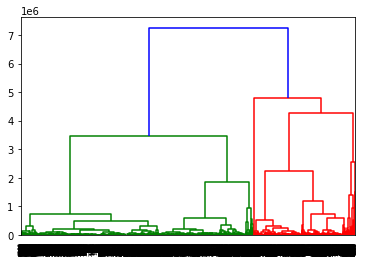

In [ ]:
random.seed(7)
# Use the linkage() function
distance_matrix = linkage(data_cluster, method = 'ward', metric = 'euclidean')
# Create a dendrogram
dn = dendrogram(distance_matrix)
# Display the dendogram
plt.show()

We apply the k-means and the elbow method with the algorithm created by us: the plot is too flat to choose a k uniquely. Let's try another method.

(NOTE: In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.)

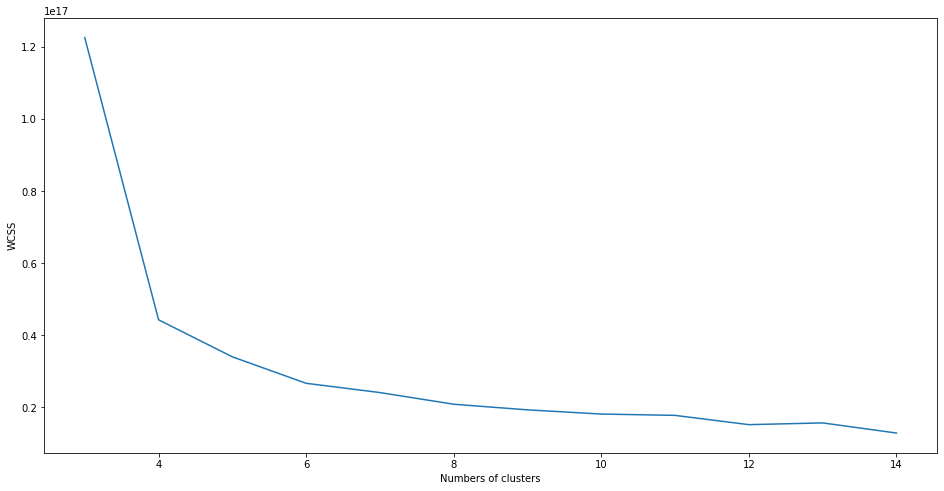

In [ ]:
wcss=[]
for i in range(3,15):
  label,centri,dd = okm.k_means_mio(data_cluster,i)
  wcss.append((sum(dd.min(axis=1)))**2)

plt.figure(figsize=(16,8))
plt.xlabel('Numbers of clusters')
plt.ylabel('WCSS')
plt.plot(range(3,15),wcss)
plt.show()

As an alternative method to choose the number of clusters we use Gap statistic.

It compares $Wcss$ ,the withiness-variance that we have already calculated by implementing the elbow method with the expected values under uniform distribution of the data $W_{kb}$.
The  gap statistic is: 
$G(k) = \frac{1}{B} \sum_b \log(W_{kb}) - \log ( Wcss) $. 
We shoud choose the best k which is equal to the minimum k such that $G(k) \geq G(k+1) - s_{k+1}$, where $s_k = \sigma_k \cdot \sqrt(1+ \frac{1}{B}) $.

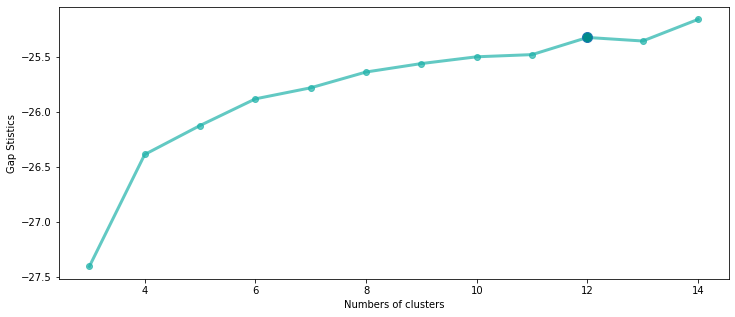

12


In [ ]:
okm.gap_stat(data_cluster, wcss)

This method advises us to choose k = 12.
This is the number of clusters we choose, because it also corresponds to the real number of genres present in the dataset.
We implement it with the chosen k = 12.

In [ ]:
label_vector,centroids,distances= okm.k_means_mio(data_cluster, k=12)

Now we need to launch k-means ++ using the sklearn library, but first we give a look to the elbow method to choose k (second method used).


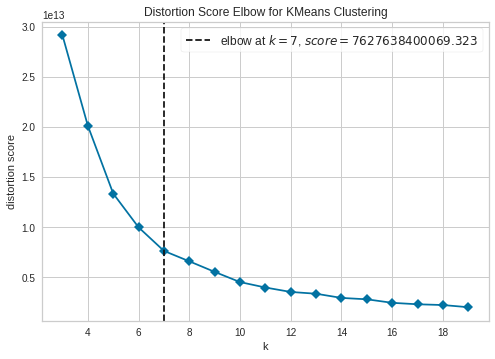

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), metric='distortion', timings=False)
visualizer.fit(data_cluster)
visualizer.show()

The elbow, that is the most "abrupt" descent, is precisely at 7.
But we implement in with k=12 to compare the two differents algorithms.

In [ ]:
kmeans=KMeans(init='k-means++', n_clusters=12)
kmeans.fit(data_cluster)

KMeans(n_clusters=12)

To compare our results with those of k-means ++ we follow two different approaches.
First let's calculate the silhouette_score: it ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. We use  the Euclidean distance.

In [ ]:
print('silhouette score for our k-means:')
print(silhouette_score(data_cluster,label_vector))
print('silhouette score for k-means++:')
print(silhouette_score(data_cluster,kmeans.labels_))

silhouette score for our k-means:
0.5100485516248273
silhouette score for k-means++:
0.6958918874905508


Note that the difference in the two algorithms lies only in the initialization of the centroids.
In this case the k-means ++ gets better results than ours!
The second approach consists in evaluating the accuracy starting from the confusion matrix. Accuracy is equal to the number of correct predictions on the total, obviously with respect to the theoretical classification.


In [ ]:
print(len(data['class_teo'].unique()))

12


In [ ]:
label_vector_1,centroids,_= okm.k_means_mio(data_cluster,k=12)
kmeans_1=KMeans(init='k-means++', n_clusters=12)
kmeans_1.fit(data_cluster)

print('Accuracy score for our k-means:')
print(round(accuracy_score(data['class_teo'], label_vector_1),2))
print('Accuracy for k-means++:')
print(round(accuracy_score(data['class_teo'], kmeans_1.labels_),2))

Accuracy score for our k-means:
0.06
Accuracy for k-means++:
0.07


The difference is not substantial.
It is not surprising that the value is low: we have many variables that do not directly affect the musical genre.

##Pivot table



First of all we have to choose the variable to compute the pivot table, let's start with language. We have 15 different language.

In [ ]:
print(data['track_language_code'].unique())

['en', 'tr', 'sw', 'el', 'ar', ..., 'sr', 'ru', 'pt', 'de', 'cs']
Length: 15
Categories (15, object): ['en', 'tr', 'sw', 'el', ..., 'ru', 'pt', 'de', 'cs']


In [ ]:
round(pd.crosstab(data['track_language_code'], label_vector,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,Total
track_language_code,,,,,,,,,,,,,
ar,0.00,0.0,0.00,0.00,0.11,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.04
cs,0.00,0.0,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.02
de,0.00,0.0,0.00,0.00,0.00,0.00,0.93,0.00,0.00,0.0,0.08,0.35,0.04
el,0.00,0.0,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.05
en,30.51,0.0,45.49,52.47,65.29,53.57,50.93,12.79,29.23,1.9,49.60,30.10,50.04
es,0.00,0.0,1.72,1.64,0.20,0.00,0.00,0.00,0.00,0.0,0.16,0.00,0.59
fr,0.00,0.0,0.00,0.58,0.03,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.09
it,0.00,0.0,0.00,0.74,0.00,0.00,0.00,0.00,0.00,0.0,0.32,0.00,0.14
pt,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.16,0.00,0.02


From the previous tables, we can deduce that cluster 4 have an  higher percentage of English songs than the others(which is also the most common language).
In cluster like 0,7 and 8 a we have almost only songs from unknown languages; while in cluster 5 and 6 more or less half are English and half unknown.
We have three different 'categories' of clusters: English majority, unknown majority and half and half.
The other languages ​​are present, in general, in rather insignificant percentages.
It is not surprising that there are so many 'unknowns' because they are values ​​that we have filled in and in which there will be many different languages.

 Now let's work with the 'track_interest' variable which represents the number of people who find that song interesting.
We first divided it into 4 categories based on quantils.

In [ ]:
q=np.quantile(data['track_interest'],q=[0,0.25,0.5,0.75,1])
print(q)
data['track_interest'] = pd.cut(data['track_interest'], q)
data['track_interest']=data['track_interest'].astype('category')

[     63.      573.     1107.     2328.5 3293557. ]


In [ ]:
round(pd.crosstab(data['track_interest'],kmeans.labels_ ,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,Total
track_interest,,,,,,,,,,,,,
"(63.0, 573.0]",30.54,21.38,26.21,0.0,0.0,10.43,0.0,20.24,0.0,0.00,0.0,0.46,25.04
"(573.0, 1107.0]",27.68,25.66,23.46,0.0,0.0,26.09,0.0,26.46,0.0,14.58,0.0,0.92,24.96
"(1107.0, 2328.5]",25.36,29.86,22.89,0.0,0.0,29.57,0.0,26.56,0.0,13.54,0.0,22.94,24.99
"(2328.5, 3293557.0]",16.43,23.11,27.44,100.0,100.0,33.91,100.0,26.74,100.0,71.88,100.0,75.69,25.01


From the pivot table we can say that Cluster 3,4,8 and 10 only have songs with very high values ​​(after the third quantile) of 'votes for interesting'; similarly 9 and 11. The others are fairly uniform in the various categories, only 0 has a higher percentage of values ​​in the minor category than the others.


3. Now we use 'album_listens' and once again we create the categories first.

In [ ]:
q=np.quantile(data['album_listens'],q=[0,0.25,0.5,0.75,1])
print(q)
data['album_listens'] = pd.cut(data['album_listens'], q)
data['album_listens']=data['album_listens'].astype('category')

[    -1.    2519.    5339.   13440.5 674347. ]


In [ ]:
round(pd.crosstab(data['album_listens'], kmeans.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,Total
album_listens,,,,,,,,,,,,,
"(-1.0, 2519.0]",32.29,20.22,16.04,0.0,0.0,6.96,0.0,32.08,0.0,0.0,0.0,0.0,24.24
"(2519.0, 5339.0]",28.08,28.81,22.94,0.0,0.0,20.00,0.0,28.03,0.0,0.0,0.0,0.0,25.19
"(5339.0, 13440.5]",24.05,25.92,32.38,0.0,0.0,26.09,0.0,24.55,0.0,0.0,0.0,0.0,25.28
"(13440.5, 674347.0]",15.58,25.06,28.64,100.0,100.0,46.96,100.0,15.33,100.0,100.0,100.0,100.0,25.29


Again cluster 3,4,6,8,9,10 and 11 contains only songs with a lot of listeners.
In general, all clusters have a lower percentage than the others in the category which identifies a relatively lower number of listeners.

The next variable we consider is the duration, which is certainly a significant feature of the songs.
Here too we divide into categories.

In [ ]:
q=np.quantile(data['track_duration'],q=[0,0.25,0.5,0.75,1])
print(q)
data['track_duration'] = pd.cut(data['track_duration'], q)
data['track_duration']=data['track_duration'].astype('category')

[  18.  153.  210.  283. 3033.]


In [ ]:
round(pd.crosstab(data['track_duration'], kmeans.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,Total
track_duration,,,,,,,,,,,,,
"(18.0, 153.0]",26.20,27.76,20.98,0.0,25.0,17.39,37.14,25.07,64.71,32.81,100.0,28.44,25.17
"(153.0, 210.0]",26.00,25.96,22.08,100.0,25.0,30.43,35.71,25.91,23.53,35.42,0.0,25.69,25.27
"(210.0, 283.0]",22.37,25.51,27.94,0.0,0.0,21.74,18.57,27.86,5.88,17.19,0.0,25.23,24.78
"(283.0, 3033.0]",25.43,20.78,29.00,0.0,50.0,30.43,8.57,21.17,5.88,14.58,0.0,20.64,24.78


Cluster 3 only has songs that last 2.5-3.5 minutes, while Cluster 10 has only songs in category that is up to 2.5. Main part of the others is more uniform, and have almost all percentages between 20/30%.
Exceptions are the 4 and 8 for examples.

Next variable is 'album_type' for which there are 5 different categories.

In [ ]:
print(data['album_type'].unique())

['Album', 'Single Tracks', 'Live Performance', 'Radio Program', 'unknown']
Categories (5, object): ['Album', 'Single Tracks', 'Live Performance', 'Radio Program',
                         'unknown']


In [ ]:
round(pd.crosstab(data['album_type'], kmeans.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,Total
album_type,,,,,,,,,,,,,
Album,47.70,80.57,93.86,100.0,100.0,81.74,68.57,75.12,100.0,85.42,100.0,95.41,70.18
Live Performance,15.57,5.63,2.05,0.0,0.0,2.61,31.43,8.91,0.0,14.58,0.0,0.92,9.42
Radio Program,34.29,7.50,1.47,0.0,0.0,9.57,0.00,11.05,0.0,0.00,0.0,1.83,17.12
Single Tracks,0.90,1.65,0.70,0.0,0.0,6.09,0.00,2.69,0.0,0.00,0.0,0.46,1.19
unknown,1.54,4.65,1.92,0.0,0.0,0.00,0.00,2.23,0.0,0.00,0.0,1.38,2.10


The most present is 'Album', 70%, which in fact characterizes all the clusters except for 0.
Radio Program  has a relatively significant percentage, 34%, in 0 and 'Live Performance' 15%.

Now let's look at 'track_lyricist' that has 9 different categories.

In [ ]:
print(data['track_lyricist'].unique())

['unknown', 'Chhom Nimol', 'Sami Abu Shumays', 'meg baird', 'Brendan Quinn', 'traditional', 'Ed Caspers', 'Jason Hodges', 'Wesley Willis']
Categories (9, object): ['unknown', 'Chhom Nimol', 'Sami Abu Shumays', 'meg baird', ...,
                         'traditional', 'Ed Caspers', 'Jason Hodges', 'Wesley Willis']


In [ ]:
round(pd.crosstab(data['track_lyricist'], kmeans.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,Total
track_lyricist,,,,,,,,,,,,,
Brendan Quinn,0.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02
Chhom Nimol,0.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06
Ed Caspers,0.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02
Jason Hodges,0.03,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01
Sami Abu Shumays,0.03,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01
Wesley Willis,0.00,0.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07
meg baird,0.03,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01
traditional,0.03,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01
unknown,99.64,99.47,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,99.78


This variable is not interesting at all because it almost only has 'unknown'.

Now let's focus on the gender variable which is the one that interests us the most. These are the different genres we have:

In [ ]:
print(data['track_genre_top'].unique())

['Hip-Hop', 'Pop', 'Folk', 'Jazz', 'Rock', ..., 'Blues', 'Classical', 'Old-Time / Historic', 'Instrumental', 'Experimental']
Length: 12
Categories (12, object): ['Hip-Hop', 'Pop', 'Folk', 'Jazz', ..., 'Classical', 'Old-Time / Historic',
                          'Instrumental', 'Experimental']


In [ ]:
round(pd.crosstab(data['track_genre_top'], kmeans.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,Total
track_genre_top,,,,,,,,,,,,,
Blues,0.93,0.60,0.04,0.0,0.0,0.00,0.00,1.58,0.00,1.56,0.0,0.46,0.71
Classical,1.16,0.60,2.09,0.0,50.0,16.52,51.43,6.96,0.00,9.38,0.0,5.05,2.83
Electronic,11.53,33.38,35.75,100.0,25.0,12.17,1.43,24.05,29.41,8.33,0.0,49.08,23.20
Experimental,0.00,0.00,0.25,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,5.05,0.18
Folk,11.58,8.03,6.51,0.0,0.0,0.00,0.00,7.61,0.00,39.06,0.0,0.46,9.34
Hip-Hop,3.89,12.08,15.89,0.0,0.0,18.26,0.00,9.10,70.59,28.65,100.0,10.55,9.73
Instrumental,0.05,0.38,1.31,0.0,0.0,0.87,30.00,0.28,0.00,0.52,0.0,8.72,0.90
International,2.39,0.60,0.25,0.0,0.0,0.00,2.86,0.74,0.00,0.00,0.0,7.34,1.42
Jazz,2.37,1.65,3.19,0.0,0.0,5.22,1.43,2.88,0.00,5.21,0.0,0.46,2.58


First we note that the most present genres are: Rock (42%), Electronic (23%) and finally Folk and Hip-Hop both at about 9%.

Now let's try to characterize each cluster.

*   Cluster 0: The highest percentage is the one of **Rock**, about 58%. 



*   Cluster 1:Here we have **Rock** at 41% follow by Electronic with 33%

*   Cluster 2: **Electronic** has the majority with 35%  but also Rock is quite present.

*   Cluster 3: **Electronic** 100%

*   Cluster 4: Here 'wins' **Classical** with 50% 

*   Cluster 5: The highest percentage is **Rock** at 31% follow by Hip-Hop

*   Cluster 6: The highest percentage is **Classical** at 51% follow by Instrumental
*   Cluster 7: Here 'wins' **Rock** with 34%, follow by Electronic

*   Cluster 8: **Hip-Hop** 80%.

*   Cluster 9: The highest percentage is **Folk** at 40% follow by Hip-Hop.
*   Cluster 10: **Hip-Hop** 100%



*   Cluster 11:Here we have **Electronic** at 50% 




We can say that it is easy to find a genre with a higher percentage of the others for each cluster, but there are genres that are never preponderant.
Therefore there is no direct cluster-gender association, mainly because some are present in a very low percentage in the dataset and k-means tends to balance cardinalities.

Now we will do this process again, but using only the features and tracks datasets, so with fewer variables but more songs (lines).
We perform the same pre-processing steps we did previously.

In [ ]:
tr=pd.read_csv('/content/drive/MyDrive/ADM-HW4/data/csv_files/tracks.csv')

In [ ]:
tr=tr.drop(['artist_name','artist_location','artist_website','artist_wikipedia_page','artist_related_projects','set_split','set_subset'],axis=1)
tr= tr.drop(['artist_latitude','artist_longitude'],axis=1)

Let's merge the datasets that already have the dimensionality reduction because we had done it separately.

In [ ]:
data_large=tr.merge(features, on='track_id')
data_large.shape

(106574, 562)

In [ ]:
data_large= data_large[data_large['track_genre_top' ].notna()]

In [ ]:
data_large=data_large.drop(['album_date_released'],axis=1)
#,'track_genre_top', teniamolo, 'album_type' anche questo, tack license, track_composer, track_lyricist (solo 12 cat), track_publsher (23)
data_large=data_large.drop(['track_information','track_date_recorded'],axis=1)
data_large=data_large.drop(['artist_members','artist_active_year_begin','artist_active_year_end','artist_associated_labels','artist_bio','artist_date_created'],axis=1)  
data_large=data_large.drop(['album_date_created','album_engineer','album_information','album_producer'],axis=1)
data=data_large.drop(['track_date_created'],axis=1)
data=data_large.drop(['track_genres_all'],axis=1)

In [ ]:
data_large=data_large.fillna('unknown')

In [ ]:
data_large.select_dtypes(include=[int]).isna().sum()
data_large.select_dtypes(include=[float]).isna().sum()
data_large.select_dtypes(include=[object]).isna().sum()

album_tags             0
album_title            0
album_type             0
artist_tags            0
track_composer         0
track_date_created     0
track_genre_top        0
track_genres           0
track_genres_all       0
track_language_code    0
track_license          0
track_lyricist         0
track_publisher        0
track_tags             0
track_title            0
dtype: int64

We need to fix categorical variables with a lot of missing data.

In [ ]:
data_large['track_tags'] = data_large['track_tags'] .astype("category") 
data_large['track_genres'] = data_large['track_genres'] .astype("category") 
data_large['code_track_tags'] = pd.factorize(data_large['track_tags'])[0] + 1
data_large['code_track_genres'] = pd.factorize(data_large['track_genres'])[0] + 1

data_large['track_language_code'] = data_large['track_language_code'] .astype("category") 
data_large['language'] = pd.factorize(data_large['track_language_code'])[0] + 1

In [ ]:
data_large['album_tags'] = data_large['album_tags'] .astype("category") 
data_large['code_album_tags'] = pd.factorize(data_large['album_tags'])[0] + 1

data_large['album_title'] = data_large['album_title'] .astype("category") 
data_large['code_album_title'] = pd.factorize(data_large['album_title'])[0] + 1

data_large['artist_tags'] = data_large['artist_tags'] .astype("category") 
data_large['code_artist_tags'] = pd.factorize(data_large['artist_tags'])[0] + 1

data_large['track_title'] = data_large['track_title'] .astype("category") 
data_large['code_track_title'] = pd.factorize(data_large['track_title'])[0] + 1

In [ ]:
data_large['album_type'] = data_large['album_type'] .astype("category") 
data['code_album_type'] = pd.factorize(data['album_type'])[0] + 1

data_large['track_license'] = data_large['track_license'] .astype("category") 
data['code_track_license'] = pd.factorize(data['track_license'])[0] + 1

data_large['track_composer'] = data_large['track_composer'] .astype("category") 
data_large['code_track_composer'] = pd.factorize(data_large['track_composer'])[0] + 1



data_large['track_publisher'] = data_large['track_publisher'] .astype("category") 
data_large['code_track_publisher'] = pd.factorize(data_large['track_publisher'])[0] + 1

data_large['track_lyricist'] = data_large['track_lyricist'] .astype("category") 
data_large['code_track_lyricist'] = pd.factorize(data_large['track_lyricist'])[0] + 1



Clustering with k-means++!

In [ ]:
data_cluster_large=data_large.drop(['code_track_genres','track_id','track_title','track_tags','track_genres','track_language_code','artist_tags','album_title','album_tags','track_genre_top','track_lyricist','track_publisher','track_composer','album_type'],axis=1)
data_cluster_large=data_cluster_large.drop(['track_license'],axis=1)
data_cluster_large=data_cluster_large.drop(['track_genres_all','track_date_created'],axis=1)


Let's use elbow method to choose k

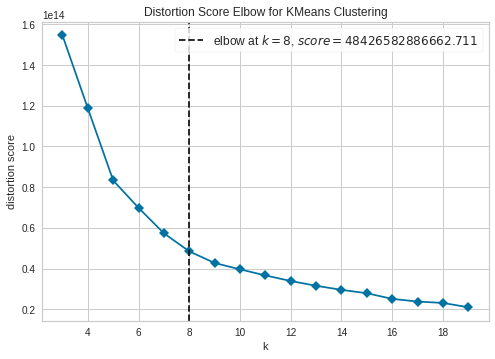

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), metric='distortion', timings=False)
visualizer.fit(data_cluster_large)
visualizer.show()

Perform k-means with the optimal value k=8

In [ ]:
kmeans_l=KMeans(init='k-means++', n_clusters=8)
kmeans_l.fit(data_cluster_large)

KMeans()

Pivot table to characterize clusters.
Again, let's start with the language.

In [ ]:
round(pd.crosstab(data_large['track_language_code'], kmeans_l.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,Total
track_language_code,,,,,,,,,
ar,0.00,0.00,0.0,0.00,0.03,0.00,0.0,0.00,0.01
bg,0.00,0.00,0.0,0.00,0.05,0.00,0.0,0.00,0.01
cs,0.02,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.01
de,0.01,0.52,0.0,1.09,0.00,0.00,0.0,0.00,0.12
el,0.00,0.00,0.0,0.00,0.04,0.00,0.0,0.00,0.01
en,6.55,20.42,0.0,1.63,34.23,25.47,0.0,22.34,18.24
es,0.20,0.09,0.0,0.00,0.33,0.77,0.0,0.00,0.25
fr,0.07,0.15,0.0,0.00,0.01,0.21,0.0,0.00,0.07
he,0.00,0.03,0.0,0.00,0.00,0.03,0.0,0.00,0.01


Compared to the previous case, we have many more 'unknow' and the most widely spoken language remains English.
All clusters have the highest percentage in unknown languages.

Track interests:

In [ ]:
q=np.quantile(data_large['track_interest'],q=[0,0.25,0.5,0.75,1])
print(q)
data_large['track_interest'] = pd.cut(data_large['track_interest'], q)
data_large['track_interest']=data_large['track_interest'].astype('category')

[      2.     456.     938.    2091. 3293557.]


In [ ]:
round(pd.crosstab(data_large['track_interest'], kmeans_l.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,Total
track_interest,,,,,,,,,
"(2.0, 456.0]",27.89,21.13,0.0,7.19,26.84,25.92,0.0,0.20,25.01
"(456.0, 938.0]",24.51,26.26,0.0,19.13,27.80,26.10,0.0,2.22,25.03
"(938.0, 2091.0]",24.27,28.06,0.0,9.77,26.22,24.31,0.0,15.02,24.97
"(2091.0, 3293557.0]",23.33,24.56,100.0,63.91,19.14,23.67,100.0,82.56,25.00


Clusters 4 and 6 only have values after the third quantile, therefore very high, while, for example, clusters 0 and 5 have lower percentages than the others in that range.
As previously we can see that there are clusters that always remain rather homogeneous (eg 3) and others with extreme values (4 or 6).

Album listens:

In [ ]:
q=np.quantile(data_large['album_listens'],q=[0,0.25,0.5,0.75,1])
print(q)
data_large['album_listens'] = pd.cut(data_large['album_listens'], q)
data_large['album_listens']=data_large['album_listens'].astype('category')

[     -1.    2602.    6092.   16219. 1193803.]


In [ ]:
round(pd.crosstab(data_large['album_listens'], kmeans_l.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,Total
album_listens,,,,,,,,,
"(-1.0, 2602.0]",21.57,25.05,0.0,0.0,29.07,24.61,0.0,0.0,23.38
"(2602.0, 6092.0]",24.27,24.20,0.0,0.0,32.38,28.63,0.0,0.0,25.55
"(6092.0, 16219.0]",28.55,28.18,0.0,0.0,24.14,22.87,0.0,0.0,25.54
"(16219.0, 1193803.0]",25.61,22.57,100.0,100.0,14.41,23.89,100.0,100.0,25.53


Clusters 4, 6 and this time also 2 and 7 have only songs with a lot of plays.
All the others are fairly uniform across the various ranges.

Track duration:

In [ ]:
q=np.quantile(data_large['track_duration'],q=[0,0.25,0.5,0.75,1])
print(q)
data_large['track_duration'] = pd.cut(data_large['track_duration'], q)
data_large['track_duration']=data_large['track_duration'].astype('category')


[    0.   146.   211.   299. 11030.]


In [ ]:
round(pd.crosstab(data_large['track_duration'], kmeans_l.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,Total
track_duration,,,,,,,,,
"(0.0, 146.0]",20.23,30.04,61.70,65.90,24.54,32.45,0.0,37.56,25.38
"(146.0, 211.0]",22.94,25.54,14.89,17.80,27.23,25.87,100.0,23.06,24.69
"(211.0, 299.0]",27.81,23.32,10.64,10.05,24.00,20.36,0.0,22.66,24.97
"(299.0, 11030.0]",29.02,21.11,12.77,6.25,24.23,21.32,0.0,16.72,24.97


Cluster 6 is always characterized by a single category, which this time is from just under 2 and a half minutes to 3.5.
There are clusters like 2 and 4 that only have "short" songs, less than two and a half minutes and others where the percentages are all similar.

Album type:

In [ ]:
round(pd.crosstab(data_large['album_type'], kmeans_l.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,Total
album_type,,,,,,,,,
Album,88.80,84.74,100.0,93.76,58.25,74.85,100.0,84.00,78.91
Live Performance,4.83,4.65,0.0,3.26,12.29,6.96,0.0,1.05,6.77
Radio Program,1.78,3.90,0.0,0.00,25.31,10.92,0.0,2.16,9.01
Single Tracks,0.42,1.97,0.0,0.00,0.55,2.17,0.0,10.25,1.18
unknown,4.17,4.74,0.0,2.99,3.60,5.10,0.0,2.55,4.13


Clusters 4 and 6 continue to have only one category which is "Albums". With the exception of cluster 5 which also has 25% of "Radio Program", it is the highest percentage in all.

Finally we analyze the genre:

In [ ]:
round(pd.crosstab(data_large['track_genre_top'], kmeans_l.labels_,normalize=1,margins=True,margins_name='Total')*100,2)

col_0,0,1,2,3,4,5,6,7,Total
track_genre_top,,,,,,,,,
Blues,0.03,0.24,0.0,0.54,0.38,0.40,0.0,0.91,0.22
Classical,0.65,2.58,100.0,7.87,3.32,4.47,0.0,9.60,2.48
Country,0.33,0.55,0.0,0.00,0.33,0.29,0.0,1.18,0.39
Easy Listening,0.03,0.04,0.0,0.14,0.09,0.00,0.0,0.07,0.05
Electronic,25.44,17.21,0.0,8.01,10.09,12.43,100.0,34.75,18.90
Experimental,26.83,22.33,0.0,0.14,14.54,23.06,0.0,5.09,21.39
Folk,3.42,6.69,0.0,0.41,8.35,8.46,0.0,3.20,5.65
Hip-Hop,11.07,5.29,0.0,2.17,2.79,5.77,0.0,7.45,7.16
Instrumental,4.21,4.43,0.0,25.24,1.45,3.28,0.0,18.03,4.19


First we note that the most present genres are: Rock (28%), Experimental (21%) and finally Electronic with 18%.

Now let's try to characterize each cluster.

*   Cluster 0: The highest percentage is the one of **Experimental**, about 26% but Rock and Electronic are also quite present,more than 20%



*   Cluster 1:Here we have **Rock** at 28% follow by Experimental with 22%

*   Cluster 2: In this case **Pop** is quite  high: 42%

*   Cluster 3: **Rock** 26%, Experimental 23%.

*   Cluster 4: **Classical** 100%
*   Cluster 5: The highest percentage is **Rock** at 45% 
*   Cluster 6: **Electronic** 100%
*   Cluster 7: Here we have **Rock** at 28% follow by Electronic with 18%


It is not easy to give a unique answer to the question 'better more rows or more features?'
Having more songs we have an extra cluster (therefore more in accordance with the real classification) and we are able to take, for example, the Experimental genre that was not so present before.

At the same time, however, with fewer variables, the clusters were better discriminated: the higher percentage is more 'distant' from the others.

Let's try to calculate the accuracy with respect to real clusters to quantify our response, obviously always taking 12 clusters, just to understand if the extra lines provide useful information.

In [ ]:
data_large['track_genre_top'] = data_large['track_genre_top'] .astype("category") 
data_large['class_teo'] = pd.factorize(data_large['track_genre_top'])[0] + 1

print('Accuracy :')
print(round(accuracy_score(data_large['class_teo'], kmeans_l.labels_),2))

Accuracy :
0.09


Accuracy score for previous k-means++ was lower so it seems that this second case is slightly better.
We believe, however, that the answer varies from case to case: more features are useful if they discriminate more on the basis of the characteristic with which you want to classify. More training examples may be useful, for example, if you are clustering without referencing a specific variable.
we would probably choose the case with fewer songs (and more features) because the gap statistics recommended a number of clusters equal to the real number of genres and this is our variable of interest.

# Algorithmic question
You are given a list of integers, A, and another integer s. Write an algorithm that outputs all the pairs in A that equal s.

In [ ]:
def algo(A,s):
    res = []
    for i in range(0,len(A)-1):
        for j in range(i+1,len(A)): # set j>i to avoid duplicates
            if A[i] + A[j]==s:
                res.append((A[i], A[j])) 
    return res

In [ ]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3]
s = 4
algo(A,s)

[(7, -3), (-2, 6), (2, 2), (1, 3)]